# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle

# Getting data

In [2]:
data = pd.read_csv('cyberbullying_tweets.csv')

# Initial Review

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [4]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


# Checking Missing Values

In [5]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

## No Missing Values found!

In [6]:
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

## Renaming columns for better understanding

In [7]:
data = data.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [8]:
data.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Adding Encoded column for sentiments

In [9]:
data["sentiment_encoded"] = data['sentiment'].replace({"religion": 1, "age": 2, "ethnicity": 3, "gender": 4, "other_cyberbullying": 5,"not_cyberbullying": 6})

In [10]:
data.head()

,text,sentiment,sentiment_encoded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6


In [11]:
data['sentiment_encoded'].value_counts()

1    7998
2    7992
4    7973
3    7961
6    7945
5    7823
Name: sentiment_encoded, dtype: int64

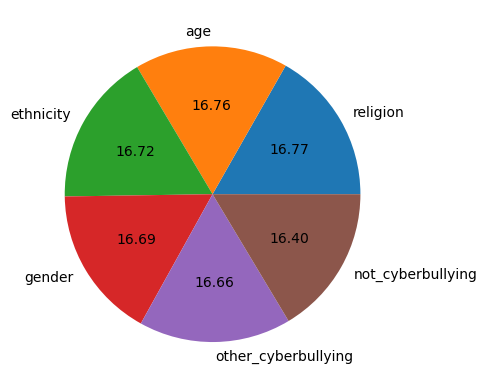

In [12]:
import matplotlib.pyplot as plt
plt.pie(data['sentiment_encoded'].value_counts(), labels=["religion" , "age" , "ethnicity" , "gender" , "other_cyberbullying" ,"not_cyberbullying"],autopct="%0.2f")
plt.show()

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TECHN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop_words = set(stopwords.words('english'))

# Preprocessing of Text

## Function to Remove Emojis

In [15]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

## Fucntion to Convert text to lowercase, remove (/r, /n  characters), URLs, non-utf characters, Numbers, punctuations,stopwords

In [16]:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

## Function to remove contractions

In [17]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

## Function to Clean Hashtags

In [18]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

## Function to Filter Special Characters such as $, &

In [19]:
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

## Function to remove multiple sequence spaces


In [20]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)


## Function to apply stemming to words

In [21]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

## Function to apply lemmatization to words

In [22]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

## Function to Preprocess the text by applying all above functions

In [23]:
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [24]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TECHN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TECHN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\TECHN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [25]:
data['cleaned_text'] = data['text'].apply(preprocess)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...


## Cleaned text added

## Dealing with Duplicates

In [26]:
data["cleaned_text"].duplicated().sum()

3041

In [27]:
data.drop_duplicates("cleaned_text", inplace=True)

# Duplicates removed

# Tokenization

In [28]:
data['tweet_list'] = data['cleaned_text'].apply(word_tokenize)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."


# Checking length of various tweet texts

In [29]:
text_len = []
for text in data.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
data['text_len'] = text_len

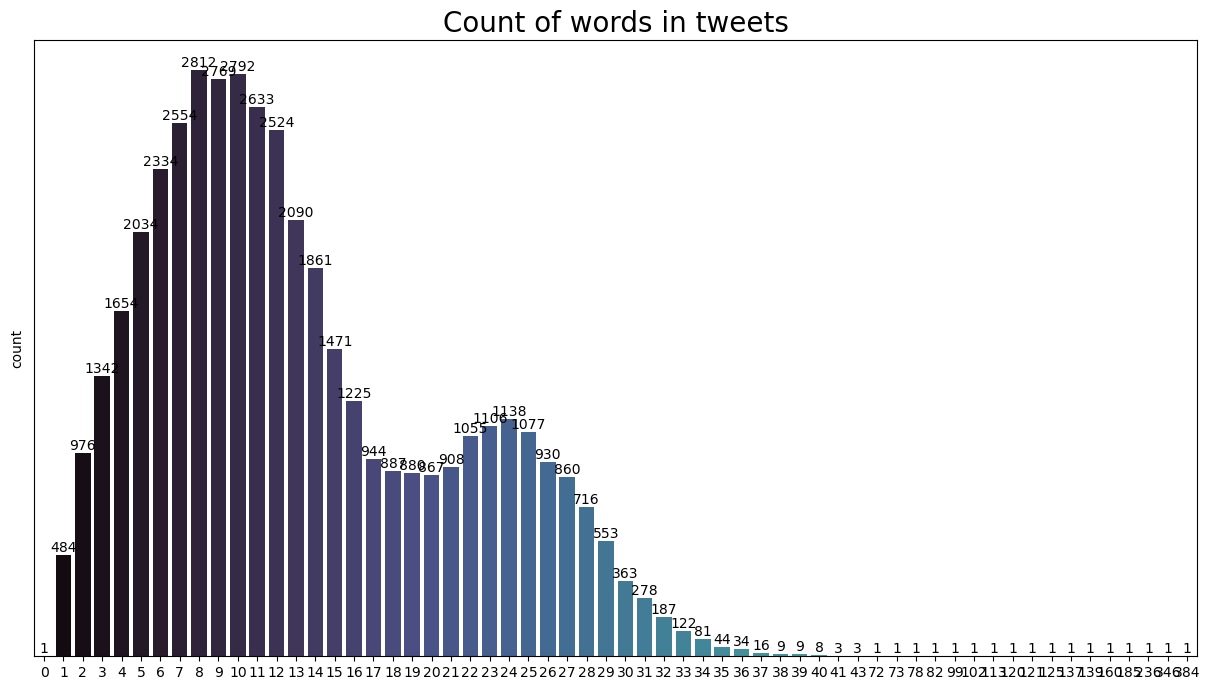

In [30]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=data, palette='mako')
plt.title('Count of words in tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Removing text without words

In [31]:
data = data[data['text_len']!=0]

In [32]:
data.shape

(44650, 6)

# Function to create WordCloud

In [33]:
def plot_wordcloud(cyberbullying_type):
    string = ""
    for i in data[data.sentiment == cyberbullying_type].cleaned_text.values:
        string = string + " " + i.strip()

    custom_mask = np.array(Image.open('statics/gmail.png'))
    mask_colors = ImageColorGenerator(custom_mask)
    wordcloud = WordCloud(background_color ='white',max_words=2000, max_font_size=256,
               random_state=42, width=custom_mask.shape[1],height=custom_mask.shape[0],
                mask = custom_mask,min_font_size = 10,color_func=mask_colors).generate(string)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

# Splitting data based on sentiment for Data Exploration

In [34]:
not_cyberbullying_type = data[data['sentiment']=='not_cyberbullying']
gender_type = data[data['sentiment']=='gender']
religion_type = data[data['sentiment']=='religion']
other_cyberbullying_type = data[data['sentiment']=='other_cyberbullying']
age_type = data[data['sentiment']=='age']
ethnicity_type = data[data['sentiment']=='ethnicity']

# Exploratory Data Analysis

# Gender Based Cyberbullying

In [35]:
gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words','Count']
top20_gender.style.background_gradient(cmap='Greens')

,Top Words,Count
0,joke,5179
1,rape,4070
2,gay,3852
3,call,1401
4,make,1283
5,rt,1221
6,woman,1182
7,bitch,1146
8,femal,1108
9,peopl,988


Text(0.5, 1.0, 'Top 20 words in Gender Cyberbullying')

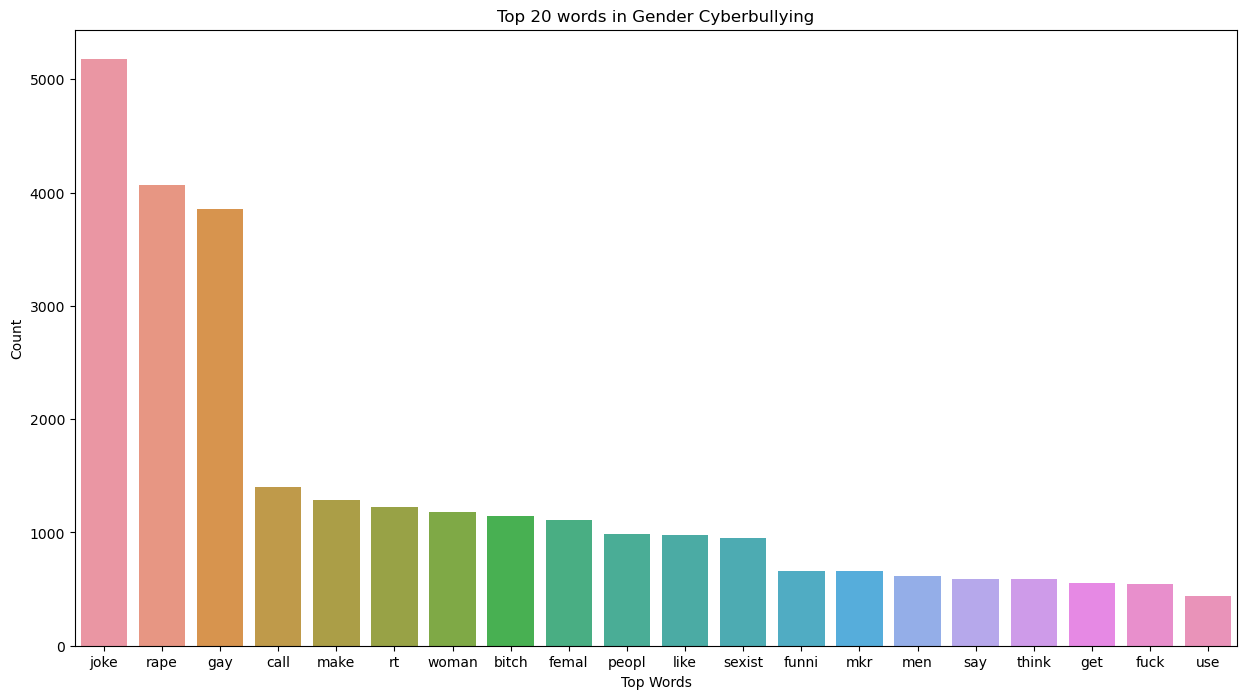

In [36]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender, y="Count", x="Top Words")
plt.title("Top 20 words in Gender Cyberbullying")

In [ ]:
plot_wordcloud('gender')

# Religion Based Cyberbullying

In [ ]:
religion = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))
top20_religion.columns = ['Top Words','Count']
top20_religion.style.background_gradient(cmap='Greens')

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion, y="Count", x="Top Words")
plt.title("Top 20 words in Religion Cyberbullying")

In [ ]:
plot_wordcloud('religion')

# Age based Cyberbullying

In [ ]:
age = Counter([item for sublist in age_type['tweet_list'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))
top20_age.columns = ['Top Words','Count']
top20_age.style.background_gradient(cmap='Greens')

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_age, y="Count", x="Top Words")
plt.title("Top 20 words in Age Cyberbullying")

In [ ]:
plot_wordcloud('age')

# Ethnicity based Cyberbullying

In [ ]:
ethnicity = Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words','Count']
top20_ethnicity.style.background_gradient(cmap='Greens')

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity, y="Count", x="Top Words")
plt.title("Top 20 words in Ethnicity Cyberbullying")

In [ ]:
plot_wordcloud('ethnicity')

# Other types of Cyberbullying

In [ ]:
other_cyberbullying = Counter([item for sublist in other_cyberbullying_type['tweet_list'] for item in sublist])
top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
top20_other_cyberbullying.columns = ['Top Words','Count']
top20_other_cyberbullying.style.background_gradient(cmap='Greens')

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_other_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Other Cyberbullying")

In [ ]:
plot_wordcloud('other_cyberbullying')

# Tweets without Cyberbullying

In [ ]:
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words','Count']
top20_not_cyberbullying.style.background_gradient(cmap='Greens')

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Not Cyberbullying")

In [ ]:
plot_wordcloud('not_cyberbullying')

In [ ]:
data.head()

In [ ]:
sentiments = ["religion", "age", "ethnicity", "gender", "other_cyberbullying","not_cyberbullying"]

# Splitting Data into Train and Test Sets

In [ ]:
X,Y = data['cleaned_text'],data['sentiment_encoded']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## tf-idf Vectorization

In [ ]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

# Trying Different ML Models

## Logistic Regression

In [ ]:
log_reg = LogisticRegression()

In [ ]:
log_cv_score = cross_val_score(log_reg,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

In [ ]:
mean_log_cv = np.mean(log_cv_score)
mean_log_cv

## Support Vector Classifier

In [ ]:
lin_svc = LinearSVC()

In [ ]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

## Naive Bayes Classifier

In [ ]:
multiNB = MultinomialNB()

In [ ]:
multiNB_cv_score = cross_val_score(multiNB,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score)
mean_multiNB_cv

## Decison Tree Classifier

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree_cv_score = cross_val_score(dtree,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_dtree_cv = np.mean(dtree_cv_score)
mean_dtree_cv

## RandomForest Classifier 

In [ ]:
rand_forest = RandomForestClassifier()

In [ ]:
rand_forest_cv_score = cross_val_score(rand_forest,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_rand_forest_cv = np.mean(rand_forest_cv_score)
mean_rand_forest_cv

## Adaboost Classifier

In [ ]:
adab = AdaBoostClassifier()

In [ ]:
adab_cv_score = cross_val_score(adab,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_adab_cv = np.mean(adab_cv_score)
mean_adab_cv

## By trying different models we can see logistic regression, svm and random forest classifier performed similarly, so among these we will go with svm model as it is more generalised and light

## Fine Tuning Support Vector Classifier

In [ ]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
             'loss':['hinge','squared_hinge'],
             'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_score_

# Model Evaluation

In [ ]:
lin_svc.fit(X_train_tf,y_train)
y_pred = lin_svc.predict(X_test_tf)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print_confusion_matrix(cm,sentiments)

In [ ]:
print('Classification Report:\n',classification_report(y_test, y_pred, target_names=sentiments))

In [ ]:
pickle.dump(tf_idf, open('vectorizer.pkl', 'wb'))
pickle.dump(lin_svc, open('model.pkl', 'wb'))